In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from spectral_clustering import *
from stability_analysis import *
from parameter_fitting import *
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

In [3]:
import warnings

warnings.filterwarnings(
    "ignore", message="KMeans is known to have a memory leak on Windows with MKL"
)

In [4]:
data = pd.read_csv(project_root + "/Data/glass.csv")

Motivation for the scaler?

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(data.drop(columns=["Type"]).to_numpy())
y_true = data["Type"].to_numpy()

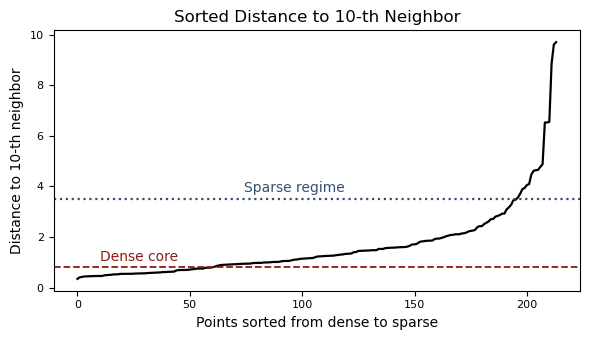

In [6]:
k = 10
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, _ = nbrs.kneighbors(X)
dist_to_kth_neighbor = distances[:, k - 1]
sorted_distances = np.sort(dist_to_kth_neighbor)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 3.5))

# Keep the curve itself black; use palette colors to highlight regimes.
primary_color = "black"
dense_color = PRESENTATION_COLORS[0]  # deep burgundy
sparse_color = PRESENTATION_COLORS[min(5, len(PRESENTATION_COLORS) - 1)]  # slate blue
ax1.plot(sorted_distances, color=primary_color, linewidth=1.6)
ax1.set_title(f"Sorted Distance to {k}-th Neighbor", fontsize=12, color="black")
ax1.set_xlabel("Points sorted from dense to sparse", color="black", fontsize=10)
ax1.set_ylabel(f"Distance to {k}-th neighbor", color="black", fontsize=10)
ax1.tick_params(axis="both", colors="black", labelsize=8)
ax1.grid(False)
ax1.axhline(
    0.8,
    color=dense_color,
    linestyle="--",
    linewidth=1.3,
    # label="Small σ disconnects tail",
)
ax1.axhline(
    3.5,
    color=sparse_color,
    linestyle=":",
    linewidth=1.6,
    # label="Large σ blurs core",
)
ax1.text(
    10,
    0.95,
    "Dense core",
    fontsize=10,
    color=dense_color,
    ha="left",
    va="bottom",
)
ax1.text(
    len(sorted_distances) - 140,
    3.65,
    "Sparse regime",
    fontsize=10,
    color=sparse_color,
    ha="left",
    va="bottom",
)

plt.tight_layout()
plt.show()

We observe that the data has varying density, which means that knn or mutual knn might be the best graph type

In [7]:
distance_matrix = get_distance_matrix_from_data(X)

In [8]:
parameter_grid_fully_connected = {
    "sim_graph_type": ["fully_connect"],
    "K": [50],  # Just a place holder, doesn't affect anything
    "sigma": [
        # 0.01, # Too small. Produce isolated clusters
        # 0.02,
        # 0.03,
        # 0.04,
        # 0.05,
        0.1,
        0.15,
        0.2,
        0.25,
        0.3,
        0.4,
        0.5,
        0.6,
        0.75,
        1.0,
        1.5,
        2.0,
    ],
    "knn": [0],
    "mutual_knn": [0],
    "epsilon": [0],
}

parameter_grid_knn = {
    "sim_graph_type": ["knn"],
    "K": [50],  # Just a place holder, doesn't affect anything
    "sigma": [0],
    "knn": [3, 5, 6, 7, 8, 10, 12, 15, 17, 20, 23, 27, 30, 35, 40],
    "mutual_knn": [0],
    "epsilon": [0],
}

parameter_grid_mutual_knn = {
    "sim_graph_type": ["mutual_knn"],
    "K": [50],  # Just a place holder, doesn't affect anything
    "sigma": [0],
    "knn": [0],
    "mutual_knn": [5, 6, 7, 8, 10, 12, 15, 17, 20, 23, 27, 30, 35, 40],
    "epsilon": [0],
}

parameter_grid_eps_neighborhood = {
    "sim_graph_type": ["eps_neighbor"],
    "K": [50],  # Just a place holder, doesn't affect anything
    "sigma": [0],
    "knn": [0],
    "mutual_knn": [0],
    "epsilon": [
        # 0.05, Too small, produce lots of singleton clusters
        # 0.1,
        # 0.15,
        0.2,
        0.25,
        0.3,
        0.5,
        0.75,
        1.0,
        1.25,
        1.5,
        2.0,
        4.0,
        8.0,
    ],
}

In [9]:
best_params_knn = find_best_params_with_eigengap_grid_search(
    distance_matrix, param_grid=parameter_grid_knn, random_state=1
)
print(best_params_knn)

best_params_mutual_knn = find_best_params_with_eigengap_grid_search(
    distance_matrix,
    param_grid=parameter_grid_mutual_knn,
    random_state=1,
)
print(best_params_mutual_knn)

{'K': 2, 'epsilon': 0, 'knn': 10, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
{'K': 4, 'epsilon': 0, 'knn': 0, 'mutual_knn': 40, 'sigma': 0, 'sim_graph_type': 'mutual_knn'}


In [10]:
params_knn = {
    "K": 3,
    "epsilon": 0,
    "knn": 5,
    "mutual_knn": 0,
    "sigma": 0,
    "sim_graph_type": "knn",
}

In [11]:
similarity_matrix_knn_best = get_similarity_matrix_from_distance_matrix(
    distance_matrix,
    sim_graph_type=best_params_knn["sim_graph_type"],
    knn=best_params_knn["knn"],
)

res_knn_best = Spectral_Clustering(
    similarity_matrix_knn_best,
    K=best_params_knn["K"],
    random_state=1,
)

similarity_matrix_knn_5 = get_similarity_matrix_from_distance_matrix(
    distance_matrix,
    sim_graph_type=params_knn["sim_graph_type"],
    knn=params_knn["knn"],
)

res_knn_5 = Spectral_Clustering(
    similarity_matrix_knn_5,
    K=params_knn["K"],
    random_state=1,
)

In [12]:
K_folds = 10

stability_res_knn_ami = cross_validation_stability_test(
    distance_matrix,
    params=best_params_knn,
    K_folds=K_folds,
    info_score=adjusted_mutual_info_score,
)

stability_res_knn_ars = cross_validation_stability_test(
    distance_matrix,
    params=best_params_knn,
    K_folds=K_folds,
    info_score=adjusted_rand_score,
)

Labels shape:  (192,)
Fold 1: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.9255
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.9256
Mean info_score: 0.9851
Std  info_score: 0.0298
Labels shape:  (192,)
Fold 1: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.9684
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 5: info_score(

<Axes: title={'center': 'Stability Across Folds'}, xlabel='Fold', ylabel='Stability Score'>

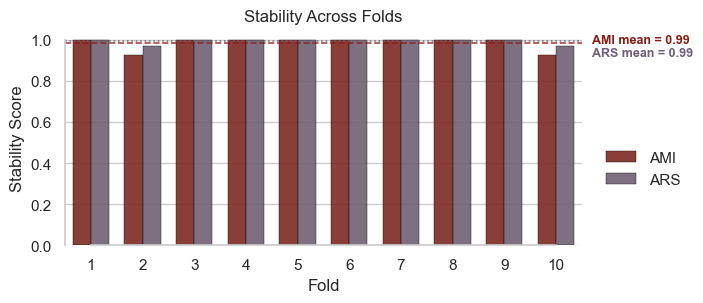

In [13]:
plot_cross_validation_stability_test_result(
    stability_res_knn_ami, stability_res_knn_ars
)

In [14]:
K_folds = 10

stability_res_knn_ami = cross_validation_stability_test(
    distance_matrix,
    params=params_knn,
    K_folds=K_folds,
    info_score=adjusted_mutual_info_score,
)

stability_res_knn_ars = cross_validation_stability_test(
    distance_matrix,
    params=params_knn,
    K_folds=K_folds,
    info_score=adjusted_rand_score,
)

Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.9378
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.8055
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.9378
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.9431
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.9395
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.8950
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.9395
Mean info_score: 0.9398
Std  info_score: 0.0556
Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.9687
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.8602
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.9687
Labels shape:  (193,)
Fold 5: info_score(

<Axes: title={'center': 'Stability Across Folds'}, xlabel='Fold', ylabel='Stability Score'>

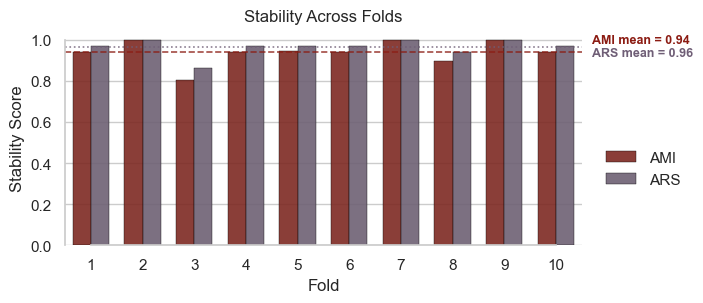

In [15]:
plot_cross_validation_stability_test_result(
    stability_res_knn_ami, stability_res_knn_ars
)

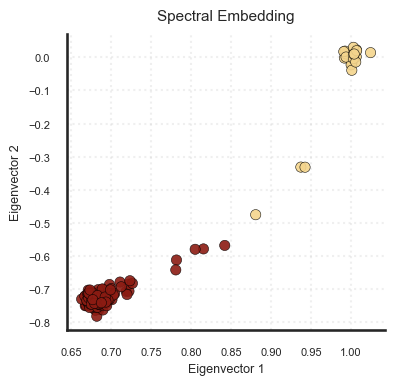

In [16]:
row_norms = np.linalg.norm(res_knn_best.eigenvectors, axis=1, keepdims=True)
row_norms[row_norms == 0] = 1e-25
normalized_embedding = res_knn_best.eigenvectors / row_norms

plot_2d_spectral_embedding(
    normalized_embedding,
    cluster_labels=res_knn_best.labels,
    # true_labels=y_true,
)

In [17]:
row_norms = np.linalg.norm(res_knn_5.eigenvectors, axis=1, keepdims=True)
row_norms[row_norms == 0] = 1e-25
normalized_embedding = res_knn_5.eigenvectors / row_norms

plot_3d_spectral_embedding(
    normalized_embedding,
    cluster_labels=res_knn_5.labels,
    # true_labels=y_true,
)

We have established that only kNN produces clusters that are not too small. Let us now try to find stable parameters for kNN, such that we get at least 3 large clusters

In [18]:
K_values = [2, 3, 4, 5, 6, 7, 8]
knn_values = [5, 10, 20, 30, 40]

knn_param_grid = {
    K: {
        knn_value: {
            "sim_graph_type": "knn",
            "K": K,
            "sigma": [0],
            "knn": knn_value,
            "mutual_knn": [0],
            "epsilon": [0],
        }
        for knn_value in knn_values
    }
    for K in K_values
}


def iter_knn_param_grid():
    for K in K_values:
        for knn_value, params in knn_param_grid[K].items():
            yield K, knn_value, params

In [19]:
knn_results = {K: {} for K in K_values}

for K, knn_value, params in iter_knn_param_grid():
    similarity_matrix = get_similarity_matrix_from_distance_matrix(
        distance_matrix,
        sim_graph_type=params["sim_graph_type"],
        knn=params["knn"],
    )
    knn_results[K][knn_value] = Spectral_Clustering(
        similarity_matrix,
        K=params["K"],
        random_state=1,
    )

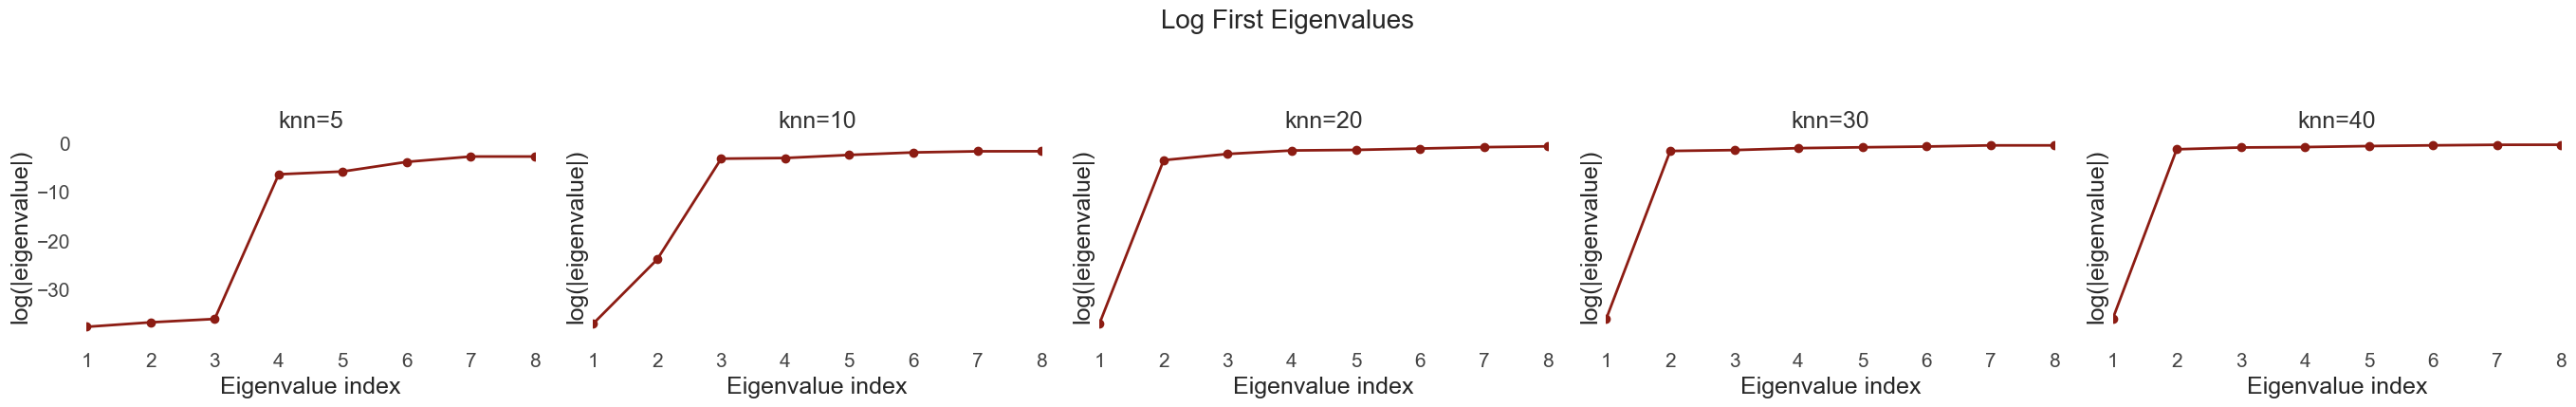

In [20]:
selected_K = 4
eigenvalue_sets = [
    knn_results[selected_K][knn_value].eigenvalues for knn_value in knn_values
]
labels = [f"knn={knn_value}" for knn_value in knn_values]
plot_eigenvalues(eigenvalue_sets, labels=labels, n_first=8)

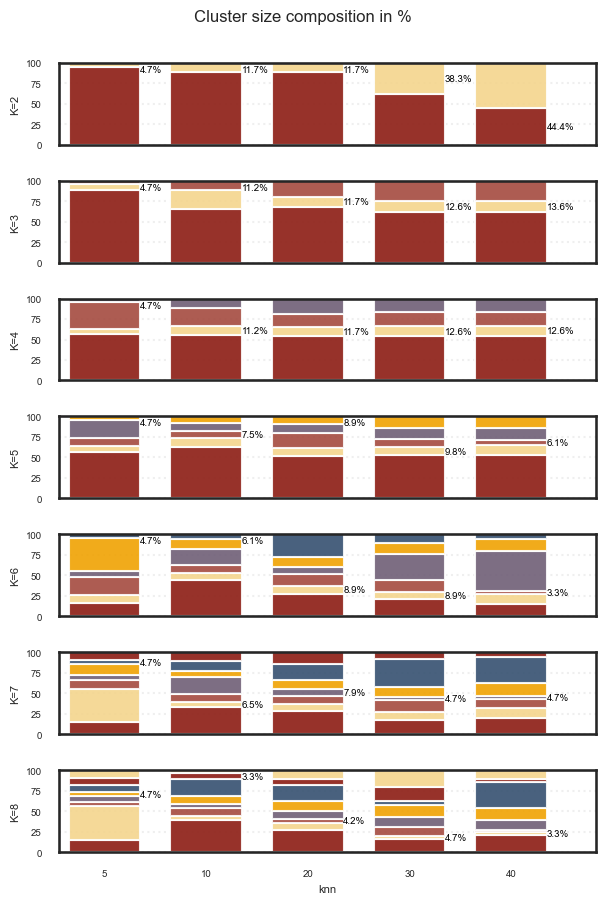

In [21]:
cluster_size_records = []

for K in K_values:
    for knn_value in knn_values:
        labels = knn_results[K][knn_value].labels
        counts = np.bincount(labels, minlength=K)
        for cluster_idx, count in enumerate(counts, start=1):
            cluster_size_records.append(
                {
                    "K": K,
                    "knn": knn_value,
                    "cluster": cluster_idx,
                    "count": int(count),
                }
            )

cluster_size_df = pd.DataFrame(cluster_size_records)


def plot_cluster_size_overview(cluster_size_df, K_values, knn_values):
    spacing_factor = 0.78
    x_positions = np.arange(len(knn_values)) * spacing_factor
    fig, axes = plt.subplots(
        len(K_values),
        1,
        figsize=(6.4, 1.35 * len(K_values)),
        sharex=True,
    )
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    palette = PRESENTATION_COLORS
    palette_len = len(palette)

    for ax, K in zip(axes, K_values):
        subset = cluster_size_df[cluster_size_df["K"] == K]
        knn_totals = (
            subset.groupby("knn")["count"]
            .sum()
            .reindex(knn_values, fill_value=0)
            .to_numpy()
        )
        knn_totals[knn_totals == 0] = 1
        bottom = np.zeros(len(knn_values))
        min_percentages = np.full(len(knn_values), 100.0)
        min_centers = np.zeros(len(knn_values))
        for cluster_idx in range(1, K + 1):
            counts = (
                subset[subset["cluster"] == cluster_idx]
                .set_index("knn")
                .reindex(knn_values, fill_value=0)["count"]
                .to_numpy()
            )
            percentages = (counts / knn_totals) * 100
            segment_bottom = bottom.copy()
            color = palette[(cluster_idx - 1) % palette_len]
            ax.bar(
                x_positions,
                percentages,
                bottom=bottom,
                width=0.55,
                alpha=0.9,
                color=color,
            )
            centers = segment_bottom + percentages / 2
            update_mask = percentages < min_percentages
            min_percentages = np.where(update_mask, percentages, min_percentages)
            min_centers = np.where(update_mask, centers, min_centers)
            bottom += percentages
        for idx, x in enumerate(x_positions):
            label_y = np.clip(min_centers[idx], 4, 92)
            ax.text(
                x + 0.27,
                label_y,
                f"{min_percentages[idx]:.1f}%",
                va="center",
                ha="left",
                fontsize=7,
                color="black",
            )
        ax.set_ylabel(f"K={K}", fontsize=8)
        ax.set_ylim(0, 100)
        ax.set_xlim(-0.35, x_positions[-1] + 0.65)
        ax.grid(axis="y", linestyle=":", alpha=0.3)
        ax.tick_params(axis="both", labelsize=7)

    axes[-1].set_xlabel("knn", fontsize=8)
    axes[-1].set_xticks(x_positions)
    axes[-1].set_xticklabels([str(k) for k in knn_values])
    fig.suptitle("Cluster size composition in %", fontsize=12, y=0.965)
    fig.tight_layout(rect=(0, 0, 1, 0.985))


plot_cluster_size_overview(cluster_size_df, K_values, knn_values)

RBF and eps neighborhood similarity produce small clusters consistent with our expectation that it is not suitable due to varying density of the data

In [22]:
K_folds = 10

stability_results = {}
stability_summary_rows = []

for K, knn_value, params in iter_knn_param_grid():
    print(f"Evaluating K={K}, k={knn_value}")
    ami_res = cross_validation_stability_test(
        distance_matrix,
        params=params,
        K_folds=K_folds,
        info_score=adjusted_mutual_info_score,
    )
    ars_res = cross_validation_stability_test(
        distance_matrix,
        params=params,
        K_folds=K_folds,
        info_score=adjusted_rand_score,
    )
    stability_results[(K, knn_value)] = {"AMI": ami_res, "ARS": ars_res}
    stability_summary_rows.append(
        {
            "K": K,
            "knn": knn_value,
            "AMI mean": ami_res["mean_score"],
            "AMI std": ami_res["std_score"],
            "ARS mean": ars_res["mean_score"],
            "ARS std": ars_res["std_score"],
        }
    )

stability_summary = (
    pd.DataFrame(stability_summary_rows)
    .sort_values(["knn", "K"])
    .reset_index(drop=True)
)

Evaluating K=2, k=5
Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.0012
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.4975
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.8878
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.8937
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.0021
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.5351
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 1.0000
Mean info_score: 0.6817
Std  info_score: 0.3838
Labels shape:  (192,)
Fold 1: info_score(train vs full) = -0.0503
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.6120
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.9481
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 1.0000
Labels shape:  (193,

c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 8 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.8826
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.8769
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.8722
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.8358
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.8538
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.8631
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.8739
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.9130
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.8327
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.7025
Mean info_score: 0.8507
Std  info_score: 0.0541


c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 8 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.9300
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.9420
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.9274
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.8868
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.9207
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.9239
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.9320
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.9395
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.8987
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.6430
Mean info_score: 0.8944
Std  info_score: 0.0854
Evaluating K=6, k=5
Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.6736
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.8605
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.6695
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.7959
Labels shape:  (193,)

c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 5 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.7076
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.6736
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.6887
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.6531
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.6570
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.5653
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.6499
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.7643
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.5083
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.7579
Mean info_score: 0.6626
Std  info_score: 0.0747


c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 5 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.6293
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.6231
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.4367
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.4381
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.4317
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.3810
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.5327
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.6863
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.3060
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.6310
Mean info_score: 0.5096
Std  info_score: 0.1217
Evaluating K=6, k=20
Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.7878
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.6407
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.7517
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.7499
Labels shape:  (193,

c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 7 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.6466
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.7873
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.7444
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.7679
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.7404
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.8461
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.8068
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.7583
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.6337
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.8456
Mean info_score: 0.7577
Std  info_score: 0.0687


c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 7 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.4269
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.6129
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.5975
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.6115
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.5909
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.8789
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.8677
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.5791
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.4576
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.9201
Mean info_score: 0.6543
Std  info_score: 0.1654
Evaluating K=7, k=5
Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.6870
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.7627
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.8632
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.7019
Labels shape:  (193,)

c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 8 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.7424
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.6663
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.6462
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.6709
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.7032
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.6598
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.7887
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.8217
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.5844
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.7449
Mean info_score: 0.7028
Std  info_score: 0.0680


c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 8 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.5775
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.4048
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.3897
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.4800
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.6028
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.5084
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.6527
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.7395
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.3732
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.6291
Mean info_score: 0.5358
Std  info_score: 0.1179
Evaluating K=7, k=20


c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 5 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.6383
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.7299
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.7963
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.6788
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.7141
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.7310
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.6689
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.8381
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.8362
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.8486
Mean info_score: 0.7480
Std  info_score: 0.0729


c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 5 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.3877
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.5527
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.6543
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.5157
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.5419
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.5647
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.4234
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.6584
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.6374
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.7000
Mean info_score: 0.5636
Std  info_score: 0.0973
Evaluating K=7, k=30
Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.7287
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.7212
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.7379
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.7709
Labels shape:  (193,

c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 8 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.8761
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.8239
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.7901
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.7600
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.8249
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.8796
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.6690
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.8603
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.8449
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.7886
Mean info_score: 0.8117
Std  info_score: 0.0605


c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 8 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.8634
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.7855
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.6151
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.6120
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.6330
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.8838
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.5360
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.8623
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.8727
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.6229
Mean info_score: 0.7287
Std  info_score: 0.1296
Evaluating K=8, k=5
Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.7812
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.7474
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.8434
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.7199
Labels shape:  (193,)

c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 8 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.8862
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.7114
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.7043
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.7088
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.7041
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.6604
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.8438
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.7162
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.7581
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.8177
Mean info_score: 0.7511
Std  info_score: 0.0697


c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 8 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.8562
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.5600
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.4450
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.5326
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.5364
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.4556
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.8254
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.5457
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.6906
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.8136
Mean info_score: 0.6261
Std  info_score: 0.1488
Evaluating K=8, k=20


c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 7 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.7624
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.7728
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.8599
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.8302
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.8047
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.6916
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.7504
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.7889
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.8438
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.6764
Mean info_score: 0.7781
Std  info_score: 0.0578


c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 7 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.6264
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.7209
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.6616
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.6503
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.6361
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.4890
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.5589
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.6249
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.6497
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.4482
Mean info_score: 0.6066
Std  info_score: 0.0791
Evaluating K=8, k=30


c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 7 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.7913
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.8365
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.8349
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.7574
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.7928
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.7943
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.8211
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.9130
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.7412
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.8132
Mean info_score: 0.8096
Std  info_score: 0.0452


c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 7 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.7172
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.6483
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.8103
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.6845
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.7277
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.7532
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.7506
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.9333
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.6534
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.6397
Mean info_score: 0.7318
Std  info_score: 0.0847
Evaluating K=8, k=40


c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.7318
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.7107
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.8268
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.8043
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.8088
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.7844
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.8749
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.7238
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.9704
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.8529
Mean info_score: 0.8089
Std  info_score: 0.0749


c:\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.4706
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.4508
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.6290
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.6317
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.7255
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.6312
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 0.9335
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.5784
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 0.9953
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.6435
Mean info_score: 0.6690
Std  info_score: 0.1673


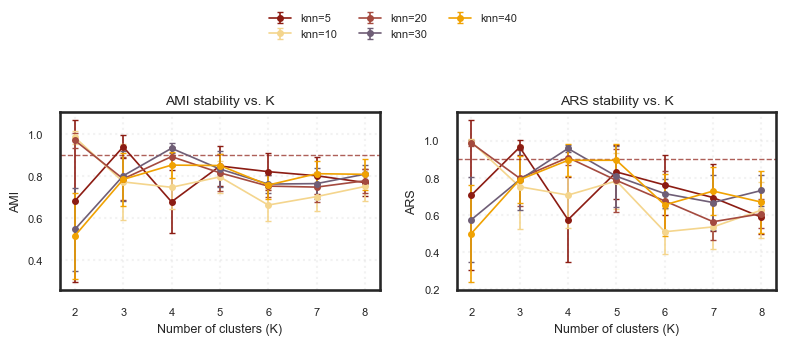

In [23]:
def plot_stability_errorbars(stability_summary, knn_values, metric, ax):
    palette = PRESENTATION_COLORS
    for idx, knn_value in enumerate(knn_values):
        subset = stability_summary[stability_summary["knn"] == knn_value].sort_values(
            "K"
        )
        color = palette[idx % len(palette)]
        ax.errorbar(
            subset["K"],
            subset[f"{metric} mean"],
            yerr=subset[f"{metric} std"],
            color=color,
            marker="o",
            markersize=4,
            capsize=2,
            linewidth=1.2,
            label=f"knn={knn_value}",
        )
    ax.axhline(
        0.9,
        color=PRESENTATION_COLORS[0],
        linestyle="--",
        linewidth=1.0,
        alpha=0.7,
    )
    ax.set_title(f"{metric} stability vs. K", fontsize=10)
    ax.set_xlabel("Number of clusters (K)", fontsize=9)
    ax.set_ylabel(metric, fontsize=9)
    ax.set_xticks(sorted(stability_summary["K"].unique()))
    ax.tick_params(axis="both", labelsize=8)
    ax.grid(linestyle=":", alpha=0.25)


fig, axes = plt.subplots(1, 2, figsize=(8.2, 3.2), sharex=True)
plot_stability_errorbars(stability_summary, knn_values, "AMI", axes[0])
plot_stability_errorbars(stability_summary, knn_values, "ARS", axes[1])
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    ncol=3,
    fontsize=8,
    loc="upper center",
    frameon=False,
    bbox_to_anchor=(0.5, 1.12),
)
plt.tight_layout(rect=(0, 0, 1, 0.92))

In [24]:
# target_K = 4
# target_knn = 20
# target_result = knn_results[target_K][target_knn]

# row_norms = np.linalg.norm(target_result.eigenvectors, axis=1, keepdims=True)
# row_norms[row_norms == 0] = 1e-25
# normalized_embedding = target_result.eigenvectors / row_norms

# plot_3d_spectral_embedding(
#     normalized_embedding,
#     cluster_labels=target_result.labels,
#     true_labels=y_true,
# )

In [25]:
# y_true[res_knn.labels == 1]